# Methods Notebook: Extracting Call Samples for KMeans Clustering

## Imports Section:

In [1]:
import numpy as np
import pandas as pd
import random
import scipy
from scipy import stats
import datetime as dt
import dask.dataframe as dd

import pytz

import re
import suncalc
import matplotlib.pyplot as plt
from matplotlib import colors
import soundfile as sf
import matplotlib.patches as patches
from pathlib import Path

In [2]:
import sys

sys.path.append("../src")

In [3]:
from core import SITE_NAMES, FREQUENCY_COLOR_MAPPINGS, FREQ_GROUPS, SEATTLE_LATITUDE, SEATTLE_LONGITUDE
import bout.assembly as bt
import bout.clustering as bt_clustering
import bout.plot as bt_plt
import activity.subsampling as ss
import activity.activity_assembly as dh

import calls.compute_features as cf
import calls.call_extraction as cextract

from cli import get_file_paths
import plot
import pipeline

['/Users/adityakrishna/duty-cycle-investigation/daily_notebook', '/Users/adityakrishna/miniconda3/envs/dc-study/lib/python311.zip', '/Users/adityakrishna/miniconda3/envs/dc-study/lib/python3.11', '/Users/adityakrishna/miniconda3/envs/dc-study/lib/python3.11/lib-dynload', '', '/Users/adityakrishna/miniconda3/envs/dc-study/lib/python3.11/site-packages', '../src', '../src', '../src', '../src/bout', '../src', '/Users/adityakrishna/duty-cycle-investigation/daily_notebook/../src/bout', '/Users/adityakrishna/duty-cycle-investigation/daily_notebook/../src']


In [4]:
def plot_dets_over_audio_seg(audio_features, spec_features, plot_dets, data_params):
    """
    Function to plot the spectrogram of a provided audio segment with overlayed detections
    """

    audio_seg = audio_features['audio_seg']
    fs = audio_features['sample_rate']
    start = audio_features['start']
    duration = audio_features['duration']

    file_dt = dt.datetime.strptime(audio_features['file_path'].name, '%Y%m%d_%H%M%S.WAV')

    UBNA_tz = pytz.timezone('US/Pacific')
    UTC_tz = pytz.timezone('UTC')

    file_dt_UTC = UTC_tz.localize(file_dt)
    file_dt_PST = file_dt_UTC.astimezone(UBNA_tz)
    file_title = f'{file_dt_PST.date()} {file_dt_PST.time()} PST'

    on = int(data_params['cur_dc_tag'].split('of')[0])
    total = int(data_params['cur_dc_tag'].split('of')[1])

    plt.figure(figsize=audio_features['figsize'])
    plt.rcParams.update({'font.size': 24})
    plt.title(f"Duty-cycle scheme: {on}min ON every {total}min", fontsize=22)
    plt.title(f"Audiomoth file recorded at {file_title}", fontsize=22)
    plt.specgram(audio_seg, NFFT=spec_features['NFFT'], cmap=spec_features['cmap'], vmax=0, vmin=spec_features['vmin'])

    orange_patch = patches.Patch(facecolor='orange', edgecolor='k', label='High-frequency calls')
    cyan_patch = patches.Patch(facecolor='cyan', edgecolor='k', label='Low-frequency calls')

    legend_patches = [orange_patch, cyan_patch]
    ax = plt.gca()
    # plot_recording_periods(ax, audio_features, data_params)
    for i, row in plot_dets.iterrows():
        rect = patches.Rectangle(((row['start_time'] - start)*(fs/2), row['low_freq']/(fs/2)), 
                        (row['end_time'] - row['start_time'])*(fs/2), (row['high_freq'] - row['low_freq'])/(fs/2), 
                        linewidth=2, edgecolor=FREQUENCY_COLOR_MAPPINGS[row['freq_group']], facecolor='none', alpha=0.8)
        
        ax.add_patch(rect)


    windows_PST = pd.date_range(file_dt_PST+pd.Timedelta(seconds=start), file_dt_PST+pd.Timedelta(seconds=start)+pd.Timedelta(seconds=duration), freq=f'180s', inclusive='both')

    plt.yticks(ticks=np.linspace(0, 1*(96/125), 6), labels=np.linspace(0, 192000/2000, 6).astype('int'))
    # plt.xticks(ticks=np.linspace(0, duration*(fs/2), len(windows_PST)), labels=windows_PST.strftime('%-M'), rotation=30)
    # times = [' ']*len(windows_PST.strftime('%-M'))
    plt.xticks(ticks=np.linspace(0, duration*(fs/2), len(windows_PST)), labels=windows_PST.strftime('%M:%S'), color='k')
    plt.ylabel("Frequency (kHz)")
    plt.xlabel("Time (seconds)")
    # plt.gcf().autofmt_xdate()
    plt.ylim(0, 96/125)
    # cbar = plt.colorbar()
    # cbar.ax.tick_params(labelsize=16)
    plt.legend(handles=legend_patches, fontsize=20, ncol=1, loc='upper right')

    plt.tight_layout()
    plt.show()

def plot_recording_periods(ax, audio_features, data_params):
    fs = audio_features['sample_rate']
    start = audio_features['start']
    duration = audio_features['duration']

    dc_tag = data_params['cur_dc_tag']
    cycle_length = 60*(int(dc_tag.split('of')[1]))
    time_on = 60*(int(dc_tag.split('of')[0]))

    window_starts = np.arange(0, 1800, cycle_length)
    for window_start in window_starts:
        if (window_start <= start+duration and window_start+time_on > start):
            if (window_start <= start):
                rect = patches.Rectangle((0, 0), (min(time_on, ((window_start+time_on)-start)))*fs/2, fs/2, 
                                        linewidth=4, edgecolor='yellow', facecolor='yellow', alpha=data_params['recording_alpha'])
            elif (window_start+time_on) >= (start+duration):
                rect = patches.Rectangle(((window_start-start)*fs/2, 0), 
                                        (min(time_on, (start+duration) - window_start))*fs/2, fs/2, 
                                        linewidth=4, edgecolor='yellow', facecolor='yellow', alpha=data_params['recording_alpha'])
            else:
                rect = patches.Rectangle(((window_start-start)*fs/2, 0), 
                                            (time_on)*fs/2, fs/2, 
                                            linewidth=4, edgecolor='yellow', facecolor='yellow', alpha=data_params['recording_alpha'])
            ax.add_patch(rect)

In [37]:
cycle_lengths = [10]
percent_ons = [1/2]
specific_dc_tag = "30of30"

data_params = dict()
data_params["year"] = '2022'
data_params['use_thresholds'] = True
data_params['use_kmeans'] = False
data_params["cycle_lengths"] = cycle_lengths
data_params["percent_ons"] = percent_ons
dc_tags = ss.get_list_of_dc_tags(data_params["cycle_lengths"], data_params["percent_ons"])
data_params["dc_tags"] = dc_tags
data_params["cur_dc_tag"] = specific_dc_tag
data_params['bin_size'] = '30'
data_params['recording_start'] = '00:00'
data_params['recording_end'] = '16:00'

pipeline_params = dict()
pipeline_params['assemble_location_summary'] = True
pipeline_params["read_csv"] = False
pipeline_params["save_activity_grid"] = False
pipeline_params["save_presence_grid"] = False
pipeline_params["save_dc_night_comparisons"] = False
pipeline_params["save_activity_dc_comparisons"] = True
pipeline_params["save_presence_dc_comparisons"] = True
pipeline_params["show_plots"] = True
pipeline_params["show_PST"] = False

site_key = 'Carp'
type_key = ''
print(site_key, type_key)

data_params["site_name"] = SITE_NAMES[site_key]
data_params["site_tag"] = site_key
data_params["type_tag"] = type_key
data_params["detector_tag"] = 'kd'

file_paths = get_file_paths(data_params)
file_paths

Carp 


{'raw_SITE_folder': '/Users/adityakrishna/duty-cycle-investigation/src/../data/raw/Carp',
 'detector': 'kd',
 'SITE_folder': '/Users/adityakrishna/duty-cycle-investigation/src/../data/2022_detector_summaries/Carp',
 'SITE_classes_folder': '/Users/adityakrishna/duty-cycle-investigation/src/../data/classifications/Carp',
 'SITE_classes_file': '/Users/adityakrishna/duty-cycle-investigation/src/../data/classifications/Carp/2022_kdCarp_call_classes.csv',
 'detector_TYPE_SITE_YEAR': 'kd__Carp_2022_thresh',
 'duty_cycled_folder': '/Users/adityakrishna/duty-cycle-investigation/src/../data/2022_detector_summaries/Carp/duty_cycled',
 'dc_dets_TYPE_SITE_summary': 'dc_kddets_Carp_summary',
 'dc_bouts_TYPE_SITE_summary': 'dc_kdbouts_Carp_summary',
 'dc_inds_TYPE_SITE_summary': 'dc_kdinds_Carp_summary',
 'dc_callrate_TYPE_SITE_summary': 'dc_kdcallrate_Carp_summary',
 'cont_callrate_TYPE_SITE_summary': 'cont_kdcallrate_Carp_summary',
 'dc_btp_TYPE_SITE_summary': 'dc_kdbtp_Carp_summary',
 'cont_btp_TY

In [52]:
init_location_sum = dh.assemble_initial_location_summary(file_paths) 
init_location_sum.reset_index(inplace=True)
init_location_sum.rename({'index':'index_in_file'}, axis='columns', inplace=True)
init_location_sum

,index_in_file,ref_time,call_start_time,call_end_time,start_time,end_time,low_freq,high_freq,file_name,input_dir,input_file,mean_freq,class,TOP1DIST,TOP2MATCH,TOP2DIST,TOP3MATCH,TOP3DIST,file_group
0,0,2022-07-13 01:01:10.959251,2022-07-13 01:01:10.959251,2022-07-13 01:01:10.963812,70.959251,70.963812,61157.797,80128.203,20220713_010000.WAV,/mnt/ubna_data_01_mir/recover-20220715/UBNA_008,/mnt/ubna_data_01_mir/recover-20220715/UBNA_00...,72792.836,nocluster,0,NaN,0,NaN,0,20220713_010000.WAV
1,1,2022-07-13 01:01:17.038521,2022-07-13 01:01:17.038521,2022-07-13 01:01:17.039521,77.038521,77.039521,74772.883,92063.492,20220713_010000.WAV,/mnt/ubna_data_01_mir/recover-20220715/UBNA_008,/mnt/ubna_data_01_mir/recover-20220715/UBNA_00...,83963.656,nocluster,0,NaN,0,NaN,0,20220713_010000.WAV
2,2,2022-07-13 01:03:23.501175,2022-07-13 01:03:23.501175,2022-07-13 01:03:23.502590,203.501175,203.502590,27681.992,29198.637,20220713_010000.WAV,/mnt/ubna_data_01_mir/recover-20220715/UBNA_008,/mnt/ubna_data_01_mir/recover-20220715/UBNA_00...,28270.480,nocluster,0,NaN,0,NaN,0,20220713_010000.WAV
3,3,2022-07-13 01:16:27.368286,2022-07-13 01:16:27.368286,2022-07-13 01:16:27.369423,987.368286,987.369423,10378.247,10612.768,20220713_010000.WAV,/mnt/ubna_data_01_mir/recover-20220715/UBNA_008,/mnt/ubna_data_01_mir/recover-20220715/UBNA_00...,10558.699,nocluster,0,NaN,0,NaN,0,20220713_010000.WAV
4,4,2022-07-13 01:19:59.530151,2022-07-13 01:19:59.530151,2022-07-13 01:19:59.532535,1199.530151,1199.532535,10025.062,10139.824,20220713_010000.WAV,/mnt/ubna_data_01_mir/recover-20220715/UBNA_008,/mnt/ubna_data_01_mir/recover-20220715/UBNA_00...,13422.763,nocluster,0,NaN,0,NaN,0,20220713_010000.WAV
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
610510,11,2022-10-17 13:40:29.671753,2022-10-17 13:40:29.671753,2022-10-17 13:40:29.673693,629.671753,629.673693,47065.336,57154.523,20221017_133000.WAV,/mnt/ubna_data_02_mir/recover-20221017/UBNA_010,/mnt/ubna_data_02_mir/recover-20221017/UBNA_01...,51536.633,nocluster,0,NaN,0,NaN,0,20221017_133000.WAV
610511,12,2022-10-17 13:42:52.847473,2022-10-17 13:42:52.847473,2022-10-17 13:42:52.848656,772.847473,772.848656,26405.229,27587.520,20221017_133000.WAV,/mnt/ubna_data_02_mir/recover-20221017/UBNA_010,/mnt/ubna_data_02_mir/recover-20221017/UBNA_01...,27048.941,nocluster,0,NaN,0,NaN,0,20221017_133000.WAV
610512,0,2022-10-17 14:12:37.142395,2022-10-17 14:12:37.142395,2022-10-17 14:12:37.143893,757.142395,757.143893,10568.051,10754.631,20221017_140000.WAV,/mnt/ubna_data_02_mir/recover-20221017/UBNA_010,/mnt/ubna_data_02_mir/recover-20221017/UBNA_01...,10678.930,nocluster,0,NaN,0,NaN,0,20221017_140000.WAV
610513,1,2022-10-17 14:12:47.538147,2022-10-17 14:12:47.538147,2022-10-17 14:12:47.540140,767.538147,767.540140,10004.002,10102.041,20221017_140000.WAV,/mnt/ubna_data_02_mir/recover-20221017/UBNA_010,/mnt/ubna_data_02_mir/recover-20221017/UBNA_01...,10035.919,nocluster,0,NaN,0,NaN,0,20221017_140000.WAV


In [53]:
def add_frequency_group_to_file_dets(file_dets, location_classes):
    print(file_dets.name)
    file_classes = location_classes[pd.to_datetime(location_classes['file_name'], 
                                                   format='%Y%m%d_%H%M%S.WAV', exact=False)==file_dets.name].copy()

    file_dets.insert(0, 'index_in_summary', file_dets.index)
    file_dets.set_index('index_in_file', inplace=True)

    classified = file_classes['KMEANS_CLASSES']!=''
    file_classes.loc[classified, 'peak_frequency'] = file_classes.loc[classified, 'peak_frequency'].astype('float64')

    file_dets.insert(0, 'peak_frequency', [np.NaN]*len(file_dets))
    file_dets.loc[file_classes['index_in_file'], 'freq_group'] = file_classes['KMEANS_CLASSES'].values
    file_dets.loc[file_classes['index_in_file'], 'peak_frequency'] = file_classes['peak_frequency'].values

    classified_dets = (file_dets['freq_group']!='')
    assert (file_dets.loc[classified_dets, 'peak_frequency'] > (file_dets.loc[classified_dets, 'low_freq'])-7000).all()
    assert (file_dets.loc[classified_dets, 'peak_frequency'] < (file_dets.loc[classified_dets, 'high_freq'])+7000).all()

    return file_dets

def add_frequency_groups_to_summary_using_kmeans(location_df, file_paths, data_params, save=True):
    location_df.insert(0, 'freq_group', '')
    location_classes = pd.read_csv(Path(file_paths['SITE_classes_file']), index_col=0)
    location_df.insert(0, 'input_file_dt', pd.to_datetime(location_df['input_file'], format='%Y%m%d_%H%M%S.WAV', exact=False))
    location_df_grouped = location_df.groupby('input_file_dt', group_keys=True)

    location_df_classified = location_df_grouped.apply(lambda x: add_frequency_group_to_file_dets(x, location_classes))

    location_df_only_classified = location_df_classified.loc[location_df_classified['freq_group']!='']
    location_df_only_classified = location_df_only_classified.droplevel(level=0)
    location_df_only_classified = location_df_only_classified.reset_index()

    if data_params['type_tag'] != '':
        location_df_only_classified = location_df_only_classified.loc[location_df_only_classified['freq_group']==data_params['type_tag']]

    if save:
        location_df_only_classified.to_csv(f'{file_paths["SITE_folder"]}/{file_paths["detector_TYPE_SITE_YEAR"]}.csv')

    return location_df_only_classified

In [54]:
file_paths['SITE_classes_file']

'/Users/adityakrishna/duty-cycle-investigation/src/../data/classifications/Carp/2022_kdCarp_call_classes.csv'

In [55]:
location_classes = pd.read_csv(Path(file_paths['SITE_classes_file']), index_col=0)
location_classes

,index,KMEANS_CLASSES,peak_frequency,SNR,index_in_file,index_in_summary,file_name,sampling_rate
0,1,HF,85440.0,3.124448,1,1,20220713_010000.WAV,250000
1,2,LF,28800.0,3.373227,2,2,20220713_010000.WAV,250000
2,0,LF,26880.0,3.464162,0,8,20220713_013000.WAV,250000
3,0,LF,32640.0,6.134378,0,11,20220713_033000.WAV,250000
4,0,LF,29760.0,22.738238,0,12,20220713_043000.WAV,250000
...,...,...,...,...,...,...,...,...
601525,9,HF,49920.0,24.423574,9,610508,20221017_133000.WAV,192000
601526,10,HF,53760.0,21.877072,10,610509,20221017_133000.WAV,192000
601527,11,HF,48960.0,21.111899,11,610510,20221017_133000.WAV,192000
601528,12,LF,26880.0,8.441074,12,610511,20221017_133000.WAV,192000


In [56]:
thresh_location_df = init_location_sum.copy()
thresh_location_df.insert(0, 'freq_group', '')
location_classes = pd.read_csv(Path(file_paths['SITE_classes_file']), index_col=0)
thresh_location_df.insert(0, 'input_file_dt', pd.to_datetime(thresh_location_df['input_file'], format='%Y%m%d_%H%M%S.WAV', exact=False))
location_df_grouped = thresh_location_df.groupby('input_file_dt', group_keys=True)

location_df_classified = location_df_grouped.apply(lambda x: add_frequency_group_to_file_dets(x, location_classes))

2022-07-13 01:00:00
2022-07-13 01:30:00
2022-07-13 02:30:00
2022-07-13 03:30:00
2022-07-13 04:30:00
2022-07-13 05:00:00
2022-07-13 05:30:00
2022-07-13 06:00:00
2022-07-13 06:30:00
2022-07-13 07:00:00
2022-07-13 07:30:00
2022-07-13 08:00:00
2022-07-13 08:30:00
2022-07-13 09:00:00
2022-07-13 09:30:00
2022-07-13 10:00:00
2022-07-13 10:30:00
2022-07-13 11:00:00
2022-07-13 12:00:00
2022-07-13 14:00:00
2022-07-13 14:30:00
2022-07-13 15:00:00
2022-07-13 15:30:00
2022-07-14 00:00:00
2022-07-14 00:30:00
2022-07-14 02:00:00
2022-07-14 03:30:00
2022-07-14 04:00:00
2022-07-14 04:30:00
2022-07-14 05:00:00
2022-07-14 05:30:00
2022-07-14 06:00:00
2022-07-14 06:30:00
2022-07-14 07:00:00
2022-07-14 07:30:00
2022-07-14 08:00:00
2022-07-14 08:30:00
2022-07-14 09:00:00
2022-07-14 09:30:00
2022-07-14 10:00:00
2022-07-14 10:30:00
2022-07-14 13:30:00
2022-07-14 14:30:00
2022-07-14 15:00:00
2022-07-14 15:30:00
2022-07-15 00:30:00
2022-07-15 02:00:00
2022-07-15 02:30:00
2022-07-15 03:00:00
2022-07-15 05:00:00


In [60]:
location_df_classified

peak_frequency  index_in_summary  \
input_file_dt       index_in_file                                     
2022-07-13 01:00:00 0                         NaN                 0   
                    1                     85440.0                 1   
                    2                     28800.0                 2   
                    3                         NaN                 3   
                    4                         NaN                 4   
...                                           ...               ...   
2022-10-17 13:30:00 11                    48960.0            610510   
                    12                    26880.0            610511   
2022-10-17 14:00:00 0                         NaN            610512   
                    1                         NaN            610513   
2022-10-17 15:30:00 0                     13440.0            610514   

                                        input_file_dt freq_group  \
input_file_dt       index_in_file                                  
2022-07-13 01:00:00 0             2022-07-13 01:00:00              
                    1             2022-07-13 01:00:00         HF   
                    2             2022-07-13 01:00:00         LF   
                    3             2022-07-13 01:00:00              
                    4             2022-07-13 01:00:00              
...                                               ...        ...   
2022-10-17 13:30:00 11            2022-10-17 13:30:00         HF   
                    12            2022-10-17 13:30:00         LF   
2022-10-17 14:00:00 0             2022-10-17 14:00:00              
                    1             2022-10-17 14:00:00              
2022-10-17 15:30:00 0             2022-10-17 15:30:00         LF   

                                                    ref_time  \
input_file_dt       index_in_file                              
2022-07-13 01:00:00 0             2022-07-13 01:01:10.959251   
                    1             2022-07-13 01:01:17.038521   
                    2             2022-07-13 01:03:23.501175   
                    3             2022-07-13 01:16:27.368286   
                    4             2022-07-13 01:19:59.530151   
...                                                      ...   
2022-10-17 13:30:00 11            2022-10-17 13:40:29.671753   
                    12            2022-10-17 13:42:52.847473   
2022-10-17 14:00:00 0             2022-10-17 14:12:37.142395   
                    1             2022-10-17 14:12:47.538147   
2022-10-17 15:30:00 0             2022-10-17 15:31:10.491035   

                                             call_start_time  \
input_file_dt       index_in_file                              
2022-07-13 01:00:00 0             2022-07-13 01:01:10.959251   
                    1             2022-07-13 01:01:17.038521   
                    2             2022-07-13 01:03:23.501175   
                    3             2022-07-13 01:16:27.368286   
                    4             2022-07-13 01:19:59.530151   
...                                                      ...   
2022-10-17 13:30:00 11            2022-10-17 13:40:29.671753   
                    12            2022-10-17 13:42:52.847473   
2022-10-17 14:00:00 0             2022-10-17 14:12:37.142395   
                    1             2022-10-17 14:12:47.538147   
2022-10-17 15:30:00 0             2022-10-17 15:31:10.491035   

                                               call_end_time   start_time  \
input_file_dt       index_in_file                                           
2022-07-13 01:00:00 0             2022-07-13 01:01:10.963812    70.959251   
                    1             2022-07-13 01:01:17.039521    77.038521   
                    2             2022-07-13 01:03:23.502590   203.501175   
                    3             2022-07-13 01:16:27.369423   987.368286   
                    4             2022-07-13 01:19:59.532535  1199.530151   
...                  

In [61]:
location_df_only_classified = location_df_classified.loc[location_df_classified['freq_group']!='']
location_df_only_classified = location_df_only_classified.droplevel(level=0)
location_df_only_classified = location_df_only_classified.reset_index()

In [62]:
location_df_only_classified

,index_in_file,peak_frequency,index_in_summary,input_file_dt,freq_group,ref_time,call_start_time,call_end_time,start_time,end_time,...,input_dir,input_file,mean_freq,class,TOP1DIST,TOP2MATCH,TOP2DIST,TOP3MATCH,TOP3DIST,file_group
0,1,85440.0,1,2022-07-13 01:00:00,HF,2022-07-13 01:01:17.038521,2022-07-13 01:01:17.038521,2022-07-13 01:01:17.039521,77.038521,77.039521,...,/mnt/ubna_data_01_mir/recover-20220715/UBNA_008,/mnt/ubna_data_01_mir/recover-20220715/UBNA_00...,83963.656,nocluster,0,NaN,0,NaN,0,20220713_010000.WAV
1,2,28800.0,2,2022-07-13 01:00:00,LF,2022-07-13 01:03:23.501175,2022-07-13 01:03:23.501175,2022-07-13 01:03:23.502590,203.501175,203.502590,...,/mnt/ubna_data_01_mir/recover-20220715/UBNA_008,/mnt/ubna_data_01_mir/recover-20220715/UBNA_00...,28270.480,nocluster,0,NaN,0,NaN,0,20220713_010000.WAV
2,0,26880.0,8,2022-07-13 01:30:00,LF,2022-07-13 01:37:39.950562,2022-07-13 01:37:39.950562,2022-07-13 01:37:39.951646,459.950562,459.951646,...,/mnt/ubna_data_01_mir/recover-20220715/UBNA_008,/mnt/ubna_data_01_mir/recover-20220715/UBNA_00...,25840.555,nocluster,0,NaN,0,NaN,0,20220713_013000.WAV
3,0,32640.0,11,2022-07-13 03:30:00,LF,2022-07-13 03:36:44.457794,2022-07-13 03:36:44.457794,2022-07-13 03:36:44.458915,404.457794,404.458915,...,/mnt/ubna_data_01_mir/recover-20220715/UBNA_008,/mnt/ubna_data_01_mir/recover-20220715/UBNA_00...,32100.697,nocluster,0,NaN,0,NaN,0,20220713_033000.WAV
4,0,29760.0,12,2022-07-13 04:30:00,LF,2022-07-13 04:53:00.337280,2022-07-13 04:53:00.337280,2022-07-13 04:53:00.343526,1380.337280,1380.343526,...,/mnt/ubna_data_01_mir/recover-20220715/UBNA_008,/mnt/ubna_data_01_mir/recover-20220715/UBNA_00...,28818.471,nocluster,0,NaN,0,NaN,0,20220713_043000.WAV
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
601525,9,49920.0,610508,2022-10-17 13:30:00,HF,2022-10-17 13:40:28.351562,2022-10-17 13:40:28.351562,2022-10-17 13:40:28.352661,628.351562,628.352661,...,/mnt/ubna_data_02_mir/recover-20221017/UBNA_010,/mnt/ubna_data_02_mir/recover-20221017/UBNA_01...,50958.004,nocluster,0,NaN,0,NaN,0,20221017_133000.WAV
601526,10,53760.0,610509,2022-10-17 13:30:00,HF,2022-10-17 13:40:28.546326,2022-10-17 13:40:28.546326,2022-10-17 13:40:28.547833,628.546326,628.547833,...,/mnt/ubna_data_02_mir/recover-20221017/UBNA_010,/mnt/ubna_data_02_mir/recover-20221017/UBNA_01...,55728.887,nocluster,0,NaN,0,NaN,0,20221017_133000.WAV
601527,11,48960.0,610510,2022-10-17 13:30:00,HF,2022-10-17 13:40:29.671753,2022-10-17 13:40:29.671753,2022-10-17 13:40:29.673693,629.671753,629.673693,...,/mnt/ubna_data_02_mir/recover-20221017/UBNA_010,/mnt/ubna_data_02_mir/recover-20221017/UBNA_01...,51536.633,nocluster,0,NaN,0,NaN,0,20221017_133000.WAV
601528,12,26880.0,610511,2022-10-17 13:30:00,LF,2022-10-17 13:42:52.847473,2022-10-17 13:42:52.847473,2022-10-17 13:42:52.848656,772.847473,772.848656,...,/mnt/ubna_data_02_mir/recover-20221017/UBNA_010,/mnt/ubna_data_02_mir/recover-20221017/UBNA_01...,27048.941,nocluster,0,NaN,0,NaN,0,20221017_133000.WAV


In [63]:
import re

def relabel_drivenames_to_mirrors(filepaths):
    drivename = re.compile(r'ubna_data_0[0-9]/')
    for i, fp in enumerate(filepaths):
        if bool(drivename.search(fp)):
            d_name = drivename.search(fp).group()
            replace_d_name = f's{d_name[:-1]}_mir/'
            filepaths[i] = filepaths[i].replace(d_name, replace_d_name)

    return filepaths


def get_params_relevant_to_data_at_location(cfg):
    data_params = dict()
    data_params["type_tag"] = ''
    data_params["cur_dc_tag"] = "30of30"
    data_params["site_tag"] = cfg['site']
    data_params['site_name'] = SITE_NAMES[cfg['site']]
    data_params['use_thresholds'] = True
    data_params['use_kmeans'] = False
    data_params['detector_tag'] = cfg['detector']
    print(f"Searching for files from {data_params['site_name']}")

    file_paths = get_file_paths(data_params)
    location_sum_df = pd.read_csv(f'{file_paths["SITE_folder"]}/{file_paths["detector_TYPE_SITE_YEAR"]}.csv', low_memory=False, index_col=0)
    location_sum_df.reset_index(inplace=True)
    location_sum_df.rename({'index':'index_in_summary'}, axis='columns', inplace=True)
    site_filepaths = relabel_drivenames_to_mirrors(location_sum_df['input_file'].copy().unique())

    data_params['good_audio_files'] = site_filepaths
    print(f"Will be looking at {len(data_params['good_audio_files'])} files from {data_params['site_name']}")

    return location_sum_df, data_params

In [64]:
cfg= dict()
cfg['site'] = 'Carp'
cfg['recording_start'] = '00:00'
cfg['recording_end'] = '16:00'
cfg['detector'] = 'bd2'
loc_df, data_param_m = get_params_relevant_to_data_at_location(cfg)

Searching for files from Carp Pond
Will be looking at 1579 files from Carp Pond


In [65]:
loc_df

,index_in_summary,freq_group,index_in_file,ref_time,call_start_time,call_end_time,start_time,end_time,low_freq,high_freq,event,class,class_prob,det_prob,individual,input_file,Site name,Recover Folder,SD Card,File Duration
0,0,LF1,0,2022-07-13 04:53:00.335500000,2022-07-13 04:53:00.335500000,2022-07-13 04:53:00.353200000,1380.3355,1380.3532,28046.0,31703.0,Echolocation,Nyctalus leisleri,0.487,0.559,-1,/mnt/ubna_data_01_mir/recover-20220715/UBNA_00...,Carp Pond,recover-20220715,8,1795.0
1,1,LF1,1,2022-07-13 04:55:13.597500000,2022-07-13 04:55:13.597500000,2022-07-13 04:55:13.612900000,1513.5975,1513.6129,23750.0,28075.0,Echolocation,Nyctalus leisleri,0.449,0.571,-1,/mnt/ubna_data_01_mir/recover-20220715/UBNA_00...,Carp Pond,recover-20220715,8,1795.0
2,2,LF1,2,2022-07-13 04:55:13.823500000,2022-07-13 04:55:13.823500000,2022-07-13 04:55:13.839600000,1513.8235,1513.8396,23750.0,28002.0,Echolocation,Nyctalus leisleri,0.513,0.591,-1,/mnt/ubna_data_01_mir/recover-20220715/UBNA_00...,Carp Pond,recover-20220715,8,1795.0
3,3,LF1,3,2022-07-13 04:55:13.988500000,2022-07-13 04:55:13.988500000,2022-07-13 04:55:14.001000000,1513.9885,1514.0010,24609.0,30884.0,Echolocation,Nyctalus leisleri,0.424,0.632,-1,/mnt/ubna_data_01_mir/recover-20220715/UBNA_00...,Carp Pond,recover-20220715,8,1795.0
4,4,LF1,4,2022-07-13 04:55:14.267500000,2022-07-13 04:55:14.267500000,2022-07-13 04:55:14.283900000,1514.2675,1514.2839,23750.0,28526.0,Echolocation,Nyctalus leisleri,0.459,0.587,-1,/mnt/ubna_data_01_mir/recover-20220715/UBNA_00...,Carp Pond,recover-20220715,8,1795.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1014391,1016410,LF1,72,2022-10-17 13:42:57.365500000,2022-10-17 13:42:57.365500000,2022-10-17 13:42:57.377900000,777.3655,777.3779,24609.0,30592.0,Echolocation,Nyctalus leisleri,0.335,0.629,-1,/mnt/ubna_data_02_mir/recover-20221017/UBNA_01...,Carp Pond,recover-20221017,10,1795.0
1014392,1016411,LF1,73,2022-10-17 13:42:58.393500000,2022-10-17 13:42:58.393500000,2022-10-17 13:42:58.409200000,778.3935,778.4092,23750.0,28366.0,Echolocation,Nyctalus leisleri,0.518,0.615,-1,/mnt/ubna_data_02_mir/recover-20221017/UBNA_01...,Carp Pond,recover-20221017,10,1795.0
1014393,1016412,LF1,74,2022-10-17 13:42:58.543500000,2022-10-17 13:42:58.543500000,2022-10-17 13:42:58.558300000,778.5435,778.5583,24609.0,30308.0,Echolocation,Nyctalus leisleri,0.281,0.548,-1,/mnt/ubna_data_02_mir/recover-20221017/UBNA_01...,Carp Pond,recover-20221017,10,1795.0
1014394,1016413,LF1,75,2022-10-17 13:42:58.794500000,2022-10-17 13:42:58.794500000,2022-10-17 13:42:58.810800000,778.7945,778.8108,23750.0,27290.0,Echolocation,Nyctalus leisleri,0.534,0.630,-1,/mnt/ubna_data_02_mir/recover-20221017/UBNA_01...,Carp Pond,recover-20221017,10,1795.0


In [66]:
files_from_loc = sorted(list(Path(f'../data/audiomoth_recordings/').glob(pattern=f'*/{site_key}/*.WAV')))
files_from_loc

[PosixPath('../data/audiomoth_recordings/recover-20220728/Carp/20220727_080000.WAV'),
 PosixPath('../data/audiomoth_recordings/recover-20220728/Carp/20220728_030000.WAV'),
 PosixPath('../data/audiomoth_recordings/recover-20220728/Carp/20220728_033000.WAV'),
 PosixPath('../data/audiomoth_recordings/recover-20220728/Carp/20220728_040000.WAV'),
 PosixPath('../data/audiomoth_recordings/recover-20220728/Carp/20220728_043000.WAV'),
 PosixPath('../data/audiomoth_recordings/recover-20220728/Carp/20220728_050000.WAV'),
 PosixPath('../data/audiomoth_recordings/recover-20220728/Carp/20220728_053000.WAV'),
 PosixPath('../data/audiomoth_recordings/recover-20220728/Carp/20220728_060000.WAV'),
 PosixPath('../data/audiomoth_recordings/recover-20220728/Carp/20220728_063000.WAV'),
 PosixPath('../data/audiomoth_recordings/recover-20220728/Carp/20220728_070000.WAV'),
 PosixPath('../data/audiomoth_recordings/recover-20220728/Carp/20220728_073000.WAV'),
 PosixPath('../data/audiomoth_recordings/recover-20220

In [67]:
file = files_from_loc[11]
file

PosixPath('../data/audiomoth_recordings/recover-20220728/Carp/20220728_080000.WAV')

In [68]:
file_path = Path(file)
filename = file_path.name
audio_file = sf.SoundFile(file_path)
fs = audio_file.samplerate
start = 0
duration = 900
audio_file.seek(int(fs*start))
audio_seg = audio_file.read(int(fs*duration))
vmax = 20*np.log10(np.max(audio_seg)) # hide anything below -rm_dB dB
vmin = 20*np.log10(np.max(audio_seg)) - 60 # hide anything below -rm_dB dB
data_params['cur_dc_tag'] = '30of30'
data_params['cycle_length'] = int(data_params['cur_dc_tag'].split('of')[-1])
data_params['time_on'] = int(data_params['cur_dc_tag'].split('of')[0])
data_params['time_on_in_secs'] = 60*data_params['time_on']
data_params['recording_alpha'] = 0.0

file_dt_start = dt.datetime.strptime(filename, '%Y%m%d_%H%M%S.WAV')
file_dt_end = file_dt_start + pd.Timedelta(minutes=30)

dc_applied_df = ss.simulate_dutycycle_on_detections(location_df_only_classified.copy(), data_params)

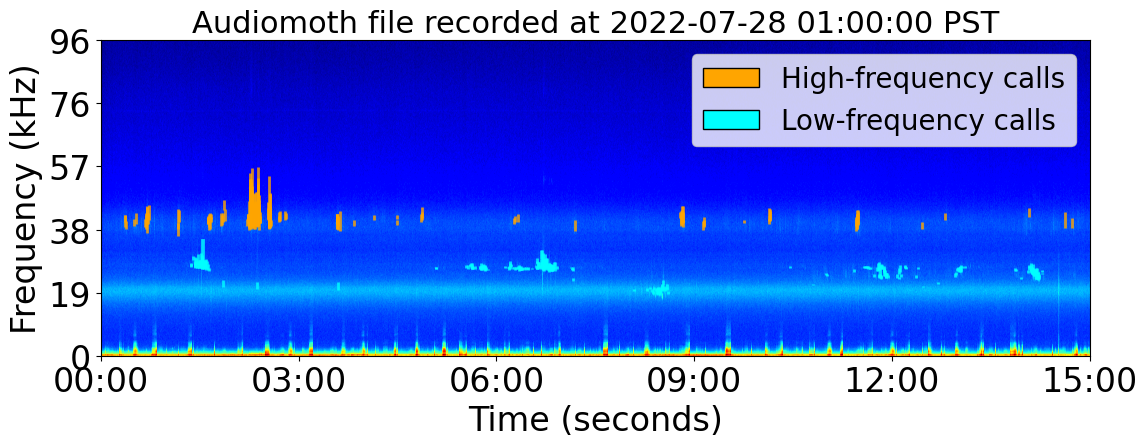

In [69]:
audio_features = dict()
audio_features['file_path'] = file_path
audio_features['audio_seg'] = audio_seg
audio_features['sample_rate'] = fs
audio_features['start'] = start
audio_features['duration'] = duration
audio_features['figsize'] = (12, 5)

spec_features = dict()
spec_features['vmax'] = vmax
spec_features['vmin'] = vmin
spec_features['NFFT'] = 1024
spec_features['cmap'] = 'jet'

plot_dets = dc_applied_df.loc[(dc_applied_df['call_start_time']>=file_dt_start)&(dc_applied_df['call_end_time']<=file_dt_end)]
plot_dets = plot_dets.loc[np.logical_and(plot_dets['start_time'] >= start, plot_dets['end_time'] <= (start+duration))]
plot_dets_over_audio_seg(audio_features, spec_features, plot_dets, data_params)
audio_file.close()

In [70]:
file_paths

{'raw_SITE_folder': '/Users/adityakrishna/duty-cycle-investigation/src/../data/raw/Carp',
 'detector': 'kd',
 'SITE_folder': '/Users/adityakrishna/duty-cycle-investigation/src/../data/2022_detector_summaries/Carp',
 'SITE_classes_folder': '/Users/adityakrishna/duty-cycle-investigation/src/../data/classifications/Carp',
 'SITE_classes_file': '/Users/adityakrishna/duty-cycle-investigation/src/../data/classifications/Carp/2022_kdCarp_call_classes.csv',
 'detector_TYPE_SITE_YEAR': 'kd__Carp_2022_thresh',
 'duty_cycled_folder': '/Users/adityakrishna/duty-cycle-investigation/src/../data/2022_detector_summaries/Carp/duty_cycled',
 'dc_dets_TYPE_SITE_summary': 'dc_kddets_Carp_summary',
 'dc_bouts_TYPE_SITE_summary': 'dc_kdbouts_Carp_summary',
 'dc_inds_TYPE_SITE_summary': 'dc_kdinds_Carp_summary',
 'dc_callrate_TYPE_SITE_summary': 'dc_kdcallrate_Carp_summary',
 'cont_callrate_TYPE_SITE_summary': 'cont_kdcallrate_Carp_summary',
 'dc_btp_TYPE_SITE_summary': 'dc_kdbtp_Carp_summary',
 'cont_btp_TY

In [71]:
bd2_location_df = pd.read_csv(f'{file_paths["SITE_folder"]}/bd2__{site_key}_2022_kmeans.csv', index_col=0)

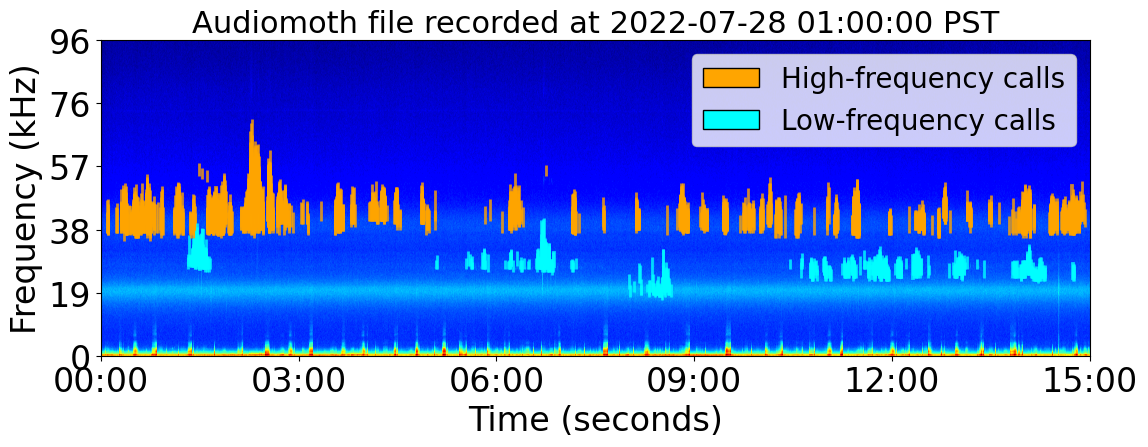

In [72]:
file_path = Path(file)
filename = file_path.name
audio_file = sf.SoundFile(file_path)
fs = audio_file.samplerate
start = 0
duration = 900
audio_file.seek(int(fs*start))
audio_seg = audio_file.read(int(fs*duration))
vmax = 20*np.log10(np.max(audio_seg)) # hide anything below -rm_dB dB
vmin = 20*np.log10(np.max(audio_seg)) - 60 # hide anything below -rm_dB dB
data_params['cur_dc_tag'] = '30of30'
data_params['cycle_length'] = int(data_params['cur_dc_tag'].split('of')[-1])
data_params['time_on'] = int(data_params['cur_dc_tag'].split('of')[0])
data_params['time_on_in_secs'] = 60*data_params['time_on']
data_params['recording_alpha'] = 0.0

file_dt_start = dt.datetime.strptime(filename, '%Y%m%d_%H%M%S.WAV')
file_dt_end = file_dt_start + pd.Timedelta(minutes=30)

dc_applied_df = ss.simulate_dutycycle_on_detections(bd2_location_df.copy(), data_params)
audio_features = dict()
audio_features['file_path'] = file_path
audio_features['audio_seg'] = audio_seg
audio_features['sample_rate'] = fs
audio_features['start'] = start
audio_features['duration'] = duration
audio_features['figsize'] = (12, 5)

spec_features = dict()
spec_features['vmax'] = vmax
spec_features['vmin'] = vmin
spec_features['NFFT'] = 1024
spec_features['cmap'] = 'jet'

plot_dets = dc_applied_df.loc[(dc_applied_df['call_start_time']>=file_dt_start)&(dc_applied_df['call_end_time']<=file_dt_end)]
plot_dets = plot_dets.loc[np.logical_and(plot_dets['start_time'] >= start, plot_dets['end_time'] <= (start+duration))]
plot_dets_over_audio_seg(audio_features, spec_features, plot_dets, data_params)
audio_file.close()